In [1]:
import sys
# adding notebooks to the system path
sys.path.insert(0, '/home/southark/notebooks')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
from tqdm import tqdm
from scipy import stats

matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *


import scanpy as sc
import bbknn

In [2]:
#load the single cell atlas

In [3]:
#here use the Korsunsky et al (Nature 2022) 

adata = adata = sc.read('/data/norman/southark/external_datasets/fibroblast_atlas_med_2022/250123_med_2022_normalized_expr_scored.h5ad')


In [4]:
[ c for c in adata.obs.cell_type_integrated.unique()]

['FBLN1+ C5',
 'C2',
 'SPARC+COL3A1+ C4',
 'C1',
 'CD34+MFAP5+ C9',
 'CXCL10+CCL19+ C11',
 'C7',
 'C6',
 'PTGS2+SEMA4A+ C8',
 'C3',
 'C12',
 'C10',
 'C0',
 'MYH11+ C13']

In [5]:
named_clusters = ['FBLN1+ C5', 'SPARC+COL3A1+ C4', 'CD34+MFAP5+ C9','CXCL10+CCL19+ C11', 'MYH11+ C13', 'PTGS2+SEMA4A+ C8']

adata = adata[adata.obs.query("cell_type_integrated in @named_clusters").index,:].copy()

In [6]:
adata

AnnData object with n_obs × n_vars = 25549 × 19952
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'biosample_id', 'donor_id', 'gut_inflam_pathology', 'inflam_score', 'nUMI', 'nGene', 'percent_mito', 'sample_type', 'cell_type_within_tissue', 'cell_type_integrated', 'experimental_condition', 'gene.program1', 'gene.program2', 'gene.program3', 'gene.program4', 'gene.program5', 'gene.program6', 'gene.program7', 'gene.program8', 'gene.program9', 'gene.program10', 'gene.program11', 'gene.program12', 'gene.program13', 'gene.program14', 'gene.program15', 'gene.program16', 'gene.program17', 'gene.program18', 'gene.program19', 'gene.program20', 'gene.program21', 'gene.program22', 'gene.program23', 'gene.program24', 'gene.program25', 'gene.program26', 'gene.program27', 'gene.program

In [7]:
# # 1. Normalize
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

In [8]:
# Find variable genes 
sc.pp.highly_variable_genes(adata, n_top_genes = 8000)

In [9]:
#sc.pp.highly_variable_genes(adata, min_mean=0.1, min_disp=0.5, n_top_genes=6000)

#Subset to HVGs and perform combat
adata = adata[:, adata.var.highly_variable].copy()

# Get value counts for each biosample_id
sample_counts = adata.obs['biosample_id'].value_counts()

# Get biosample_ids that appear more than once
keep_samples = sample_counts[sample_counts > 1].index

# Filter the AnnData object
adata = adata[adata.obs['biosample_id'].isin(keep_samples)].copy()

# Print the shape before and after to confirm
print(f"After filtering: {adata.shape[0]} cells remaining")

sc.pp.combat(adata, key='biosample_id')

After filtering: 25549 cells remaining


/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/scanpy/preprocessing/_combat.py:351: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [10]:
from sklearn.cluster import KMeans


sc.tl.pca(adata)
n_clusters = 2500
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
adata.obs['kmeans_cluster'] = kmeans.fit_predict(adata.obsm['X_pca'])

In [11]:
# Create metacells, filtering out single-cell clusters
metacells = []
metacell_obs = []
categorical_cols = ['cell_type_integrated', 'cell_type_within_tissue', 'disease__ontology_label', 'organ__ontology_label']
prog_cols = [f'prog_{i}' for i in range(58)]

for cluster in range(n_clusters):
   mask = adata.obs['kmeans_cluster'] == cluster
   if sum(mask) > 1:  # Only include clusters with >1 cell
       cluster_obs = adata.obs[mask]
       
       obs_dict = {
           'kmeans_cluster': f'cluster_{cluster}',
           'n_cells': sum(mask)
       }
       
       for col in categorical_cols:
           value_counts = cluster_obs[col].value_counts()
           obs_dict[f'{col}_composition'] = ', '.join(f'{k}({v})' for k,v in value_counts.items())
       
       for prog in prog_cols:
           obs_dict[prog] = cluster_obs[prog].mean()
           
       metacell = adata[mask].X.mean(axis=0)
       metacells.append(metacell)
       metacell_obs.append(obs_dict)

metacell_adata = sc.AnnData(
   X=np.vstack(metacells),
   var=adata.var.copy(),
   obs=pd.DataFrame(metacell_obs)
)

/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
metacell_adata.obs

,kmeans_cluster,n_cells,cell_type_integrated_composition,cell_type_within_tissue_composition,disease__ontology_label_composition,organ__ontology_label_composition,prog_0,prog_1,prog_2,prog_3,...,prog_48,prog_49,prog_50,prog_51,prog_52,prog_53,prog_54,prog_55,prog_56,prog_57
0,cluster_1,20,"SPARC+COL3A1+ C4(16), PTGS2+SEMA4A+ C8(3), MYH...","Inflammatory Fibroblasts(7), Myofibroblasts(5)...","ulcerative colitis(16), rheumatoid arthritis(4...","large intestine(16), synovial membrane of syno...",-0.0029,1.5726,0.0290,-0.0191,...,0.2295,0.4854,-0.0387,-0.0090,0.0335,0.2613,0.5827,-0.1132,-0.0457,0.1976
1,cluster_2,23,"PTGS2+SEMA4A+ C8(20), CD34+MFAP5+ C9(3), CXCL1...","WNT2B+ Fos-lo 2(12), WNT2B+ Fos-hi(9), CD34(1)...","ulcerative colitis(12), normal(9), interstitia...","large intestine(21), lung(1), minor salivary g...",0.0504,1.4404,0.0386,-0.0775,...,0.2606,0.4385,-0.1120,-0.0340,-0.0164,0.1893,0.6729,0.1054,-0.1971,-0.0041
2,cluster_3,22,"FBLN1+ C5(11), CXCL10+CCL19+ C11(5), PTGS2+SEM...","Fibroblast(7), WNT2B+ Fos-lo 2(3), RSPO3+(2), ...","normal(10), rheumatoid arthritis(3), ulcerativ...","lung(9), large intestine(7), synovial membrane...",-0.0086,1.2588,0.0912,-0.0227,...,0.3797,0.2457,-0.0756,-0.0442,-0.0137,0.2104,0.8348,-0.0627,-0.1133,0.0192
3,cluster_4,10,"SPARC+COL3A1+ C4(5), CXCL10+CCL19+ C11(4), FBL...","Sublining(9), WNT2B+ Fos-hi(1), CCL19(0), CD34...","rheumatoid arthritis(9), ulcerative colitis(1)...","synovial membrane of synovial joint(9), large ...",0.0370,1.8781,-0.0290,0.0501,...,0.5270,0.2579,-0.0205,-0.0535,0.0847,0.2911,0.5808,0.0308,-0.1111,-0.0370
4,cluster_5,4,"SPARC+COL3A1+ C4(4), CD34+MFAP5+ C9(0), CXCL10...","Sublining(3), CD34+ sublining (SC-F1)(1), CCL1...","rheumatoid arthritis(3), osteoarthritis(1), dr...","synovial membrane of synovial joint(4), large ...",-0.0028,1.9389,0.1059,0.0110,...,0.2544,0.3204,-0.0908,-0.0404,0.0027,0.3012,0.6605,-0.4413,-0.0447,0.1285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,cluster_2494,2,"CD34+MFAP5+ C9(1), FBLN1+ C5(1), CXCL10+CCL19+...","CD34+ sublining (SC-F1)(2), CCL19(0), CD34(0),...","rheumatoid arthritis(2), Sjogren syndrome(0), ...","synovial membrane of synovial joint(2), large ...",0.0101,1.1838,0.2314,0.0211,...,0.3910,0.7781,0.0753,-0.0113,-0.0768,0.4211,0.9653,1.2296,-0.0331,-0.1548
2248,cluster_2495,2,"SPARC+COL3A1+ C4(1), FBLN1+ C5(1), CXCL10+CCL1...","Sublining(2), CCL19(0), CD34(0), DKK3+ sublini...","rheumatoid arthritis(2), Sjogren syndrome(0), ...","synovial membrane of synovial joint(2), large ...",0.0452,2.0972,0.0882,0.0555,...,0.2452,0.1059,-0.1895,-0.0247,0.0602,0.0450,0.7734,-0.3609,-0.2515,-0.1634
2249,cluster_2497,2,"SPARC+COL3A1+ C4(1), FBLN1+ C5(1), CXCL10+CCL1...","CD34+ sublining (SC-F1)(2), CCL19(0), CD34(0),...","rheumatoid arthritis(2), Sjogren syndrome(0), ...","synovial membrane of synovial joint(2), large ...",-0.0397,1.1637,0.2304,-0.0096,...,0.4021,0.6276,0.0281,-0.0493,-0.0411,0.4696,0.8403,-0.5876,0.0063,-0.1678
2250,cluster_2498,4,"FBLN1+ C5(3), CXCL10+CCL19+ C11(1), CD34+MFAP5...","CD34+ sublining (SC-F1)(2), Sublining(2), CCL1...","rheumatoid arthritis(4), Sjogren syndrome(0), ...","synovial membrane of synovial joint(4), large ...",0.0363,1.7581,0.0070,0.1119,...,0.4008,0.4362,-0.0372,-0.0102,0.0144,0.1930,0.7655,-0.4330,-0.0912,0.3502


In [13]:
def get_main_annotation_with_purity(composition_string):
    components = [x.strip() for x in composition_string.split(',')]
    counts = []
    total_count = 0
    
    for comp in components:
        try:
            main_part = comp.rsplit(')', 1)[0]  
            count_str = main_part.rsplit('(', 1)[1]
            name = main_part.rsplit('(', 1)[0].strip()
            count = int(count_str)
            counts.append((name, count))
            total_count += count
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse '{comp}'")
            continue
            
    if not counts:
        return composition_string, 0
    
    # Get main annotation and its count
    main_annotation = max(counts, key=lambda x: x[1])
    purity = main_annotation[1] / total_count if total_count > 0 else 0
    
    return main_annotation[0], purity

# Apply to all columns
for col, new_col_prefix in [
    ('cell_type_integrated_composition', 'main_cluster'),
    ('cell_type_within_tissue_composition', 'main_clustname'),
    ('disease__ontology_label_composition', 'main_disease'),
    ('organ__ontology_label_composition', 'main_organ')
]:
    annotations, purities = zip(*metacell_adata.obs[col].apply(get_main_annotation_with_purity))
    metacell_adata.obs[new_col_prefix] = annotations
    metacell_adata.obs[f"{new_col_prefix}_purity"] = purities

In [14]:
# Example to see distribution of purities
print(metacell_adata.obs['main_cluster_purity'].describe())

count   2252.0000
mean       0.8216
std        0.1928
min        0.2222
25%        0.6667
50%        0.8824
75%        1.0000
max        1.0000
Name: main_cluster_purity, dtype: float64


In [15]:
# Example to see distribution of purities
print(metacell_adata.obs['main_clustname_purity'].describe())

count   2252.0000
mean       0.8038
std        0.2145
min        0.1667
25%        0.6296
50%        0.8750
75%        1.0000
max        1.0000
Name: main_clustname_purity, dtype: float64


In [16]:
# Example to see distribution of purities
print(metacell_adata.obs['main_disease_purity'].describe())

count   2252.0000
mean       0.7769
std        0.2050
min        0.2000
25%        0.6000
50%        0.8000
75%        1.0000
max        1.0000
Name: main_disease_purity, dtype: float64


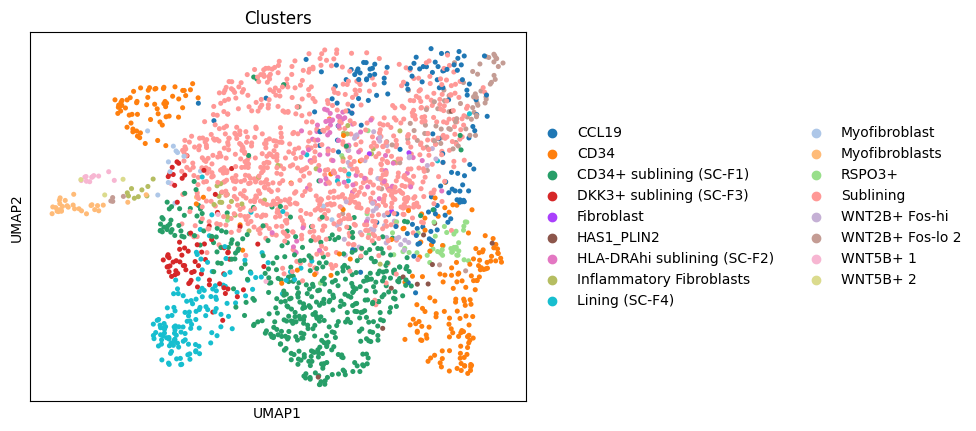

In [17]:
# UMAP

sc.tl.pca(metacell_adata)
sc.pp.neighbors(metacell_adata)
sc.tl.umap(metacell_adata)
sc.pl.umap(metacell_adata, color='main_clustname',title='Clusters')

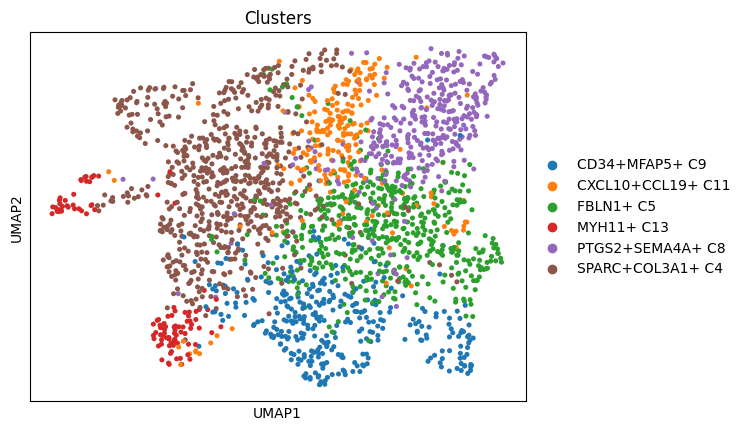

In [18]:

# UMAP

sc.tl.pca(metacell_adata)
sc.pp.neighbors(metacell_adata)
sc.tl.umap(metacell_adata)
sc.pl.umap(metacell_adata, color='main_cluster',title='Clusters')

## Import gene programs

In [19]:
codes = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_fibroblast_bulk_codes.csv', index_col=0)
codes.columns = codes.columns.astype(int)

total_codes = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_total_fibroblast_bulk_codes.csv', index_col=0)
total_codes.columns = total_codes.columns.astype(int)

comps = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_fibroblast_bulk_comps.csv', index_col=0)

### Collect guide annotations

In [20]:
fibro_mean_pop = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240311_fibroblast_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])
fibro_mean_pop.genes.index.name = 'gene_id'

Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_masked', '/normalized_matrix_p']
Loading metadata...
Done in 4.658403635025024s.
Done.


In [21]:
expanded_guides = pd.read_csv('/data/norman/southark/tfs_standardized/20240319_rescued_fibroblast_guides.csv', index_col=0)
fibro_mean_pop.cells['expanded_masked_active'] = expanded_guides['expanded_masked_active']

In [22]:
guide_library = pd.read_csv('/data/norman/southark/tfs_standardized/20240318_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef.csv', index_col=0)

guide_library['masked_active'] = fibro_mean_pop.cells['masked_active']
guide_library['expanded_masked_active'] = fibro_mean_pop.cells['expanded_masked_active']
guide_library['masked_active'].fillna(False, inplace=True)
guide_library['expanded_masked_active'].fillna(False, inplace=True)
guide_library['de_genes'] = fibro_mean_pop.cells['de_genes']

guide_library['masked_active_rpe1'].fillna(False, inplace=True)
guide_library['masked_active_fibro'].fillna(False, inplace=True)

/tmp/ipykernel_358951/3952235194.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  guide_library['masked_active'].fillna(False, inplace=True)
/tmp/ipykernel_358951/3952235194.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_library['masked_active'].fillna(False, inplace=True)
/tmp/ipykernel_358951/39

In [23]:
good_guides = guide_library.query('not seed_driven_fibro and not seed_driven_rpe1 and not bad_seed and cell_count_fibro >= 20 and ((pctl_change_fibro > 5) or (masked_active_fibro or expanded_masked_active or masked_active_rpe1))').index

gene_codes = total_codes.reindex(good_guides).dropna()
gene_codes['gene'] = gene_codes.index.map(lambda x: x.split('_')[0])
gene_codes = gene_codes.set_index('gene', append=True).swaplevel()


# Get strongest guide per gene based on absolute magnitude across all columns
guide_strengths = gene_codes.abs().sum(axis=1)
top_guides = guide_strengths.groupby('gene').nlargest(1) 
# Get index for these top guides
top_guide_idx = top_guides.index.get_level_values(2)

gene_codes_reduced = gene_codes.loc[pd.IndexSlice[:, top_guide_idx], :].droplevel(1)

In [24]:
guide_library.query('target_gene == "GFI1"')

,gene_name,target_gene,ctrl_pctl_fibro,target_pctl_fibro,pctl_change_fibro,pctl_fc_fibro,pctl_log2fc_fibro,adj_p_fibro,ctrl_coef_fibro,ctrl_abs_fibro,...,seed_matches,good_guide_fibro,good_guide_rpe1,best_guide_fibro,best_guide_rpe1,seed_driven_fibro,seed_driven_rpe1,masked_active,expanded_masked_active,de_genes
guide_identity,,,,,,,,,,,,,,,,,,,,,
GFI1_GAGAACTGGGAGGACTACTA,ENSG00000162676,GFI1,0.0000,34.1750,34.1750,inf,25.0264,0.0000,0.0002,0.0002,...,[],True,True,False,True,False,False,True,False,191.0000
GFI1_GAGAGCGGGACCTCGCACGC,ENSG00000162676,GFI1,0.0000,38.5309,38.5309,inf,25.1995,0.0000,0.0002,0.0002,...,[],True,False,False,False,False,False,True,False,319.0000
GFI1_GAGGGCGGGGACACGCGGAT,ENSG00000162676,GFI1,0.0000,30.1852,30.1852,inf,24.8473,0.0000,0.0002,0.0002,...,[],True,True,False,False,False,False,False,False,4.0000
GFI1_GAGTGCCTGGGTATGACCTC,ENSG00000162676,GFI1,0.0000,36.8209,36.8209,inf,25.1340,0.0000,0.0002,0.0002,...,[],True,False,False,False,False,True,True,False,60.0000
GFI1_GGCGATGAGTAGCTGAGTTG,ENSG00000162676,GFI1,0.0000,44.1080,44.1080,inf,25.3945,0.0000,0.0002,0.0002,...,[],True,True,True,False,False,False,True,False,194.0000
GFI1_GGCGCCCGGCCGCCCGACGG,ENSG00000162676,GFI1,0.0000,26.8604,26.8604,inf,24.6790,0.0000,0.0002,0.0002,...,['GACGG'],False,False,False,False,False,True,True,False,261.0000


In [25]:
gene_codes_reduced.loc['RUNX2'][[27,32]]

27   0.1427
32   0.5401
Name: RUNX2, dtype: float64

### Get TFs in dataset

In [26]:
good_targets = guide_library.loc[good_guides]['target_gene'].unique()
good_targets = np.intersect1d(gene_codes.index.get_level_values(0),metacell_adata.var_names)
gene_codes = gene_codes.loc[good_targets]
gene_codes_reduced = gene_codes_reduced.loc[good_targets]

# Calculate Marker gene correlations with TF expression in metacells

In [27]:
metacell_adata.X = stats.zscore(metacell_adata.X, axis=0)

# Get gene indices from var_names
genes = ['PI16', 'SPARC', 'COL3A1', 'COL1A1', 'LRRC15', 'COL11A1', 'CTHRC1', 'POSTN', 'ACTA2']
gene_expr = {}

for gene in genes:
   if gene in metacell_adata.var_names:
       gene_idx = metacell_adata.var_names.get_loc(gene)
       gene_expr[gene] = metacell_adata.X[:, gene_idx]
   else:
       print(f"{gene} not found in data")

# Convert to pandas DataFrame
gene_expr_df = pd.DataFrame(metacell_adata.X, 
                          columns=metacell_adata.var_names,
                          index=metacell_adata.obs.index)

# Filter for target genes
tf_expr = gene_expr_df[good_targets]

# Calculate correlations
correlations = {}
markers = ['PI16', 'SPARC', 'COL3A1', 'COL1A1', 'LRRC15', 'COL11A1', 'CTHRC1', 'POSTN', 'PLAGL1']

for marker in markers:
   marker_expr = gene_expr_df[marker]
   correlations[marker] = tf_expr.corrwith(marker_expr)

### Get program scores and correlate with genes

In [28]:
prog_cols = [f'prog_{i}' for i in range(58)]
prog_correlations = {}

for prog in prog_cols:
   prog_scores = metacell_adata.obs[prog]
   prog_correlations[prog] = tf_expr.corrwith(prog_scores)

In [29]:
sns.set_context('paper')

def plot_and_identify_outliers(series1, series2, size_values=None, labels=None, size_scale=100, context = 'explore', savefig = False):
    """
    Create scatter plot with outlier detection and optional point sizes.
    
    Parameters:
    series1, series2: pandas Series with matching indices
    size_values: pandas Series with matching indices for point sizes (optional)
    labels: list of strings for axis labels
    size_scale: scaling factor for point sizes (default 100)
    """
    def find_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series[(series < lower_bound) | (series > upper_bound)], lower_bound, upper_bound
    
    def find_positive_outliers(series):
        Q3 = series.quantile(0.75)
        IQR = Q3 - series.quantile(0.25)
        upper_bound = Q3 + 1.5 * IQR
        return series[series > upper_bound]
    
    # Process size values
    if size_values is not None:
        # Normalize size values to be between 20 and 200 points
        size_min = size_values.min()
        size_max = size_values.max()
        # Make small points smaller while keeping large ones visible
        normalized_sizes = ((size_values - size_values.min()) / 
                  (size_values.max() - size_values.min())) ** 2 * 300 #+ 3
    else:
        normalized_sizes = pd.Series(50, index=series1.index)  # Default size

    # print(size_values.sort_values())
    # print(normalized_sizes.sort_values())
    
    x_outliers, x_lower, x_upper = find_outliers(series1)
    y_outliers, y_lower, y_upper = find_outliers(series2)
    
    x_pos_outliers = find_positive_outliers(series1)
    y_pos_outliers = find_positive_outliers(series2)
    
    both_pos_outliers = x_pos_outliers.index.intersection(y_pos_outliers.index)
    
    print("Outliers in x-axis:")
    print(x_outliers.index.tolist())
    print("\nOutliers in y-axis:")
    print(y_outliers.index.tolist())
    print("\nPositive outliers in both axes:")
    print(both_pos_outliers.tolist())
    
    if context == 'explore':
        fig, ax = plt.subplots(figsize=(8, 8))
    elif context == 'pub':
        fig, ax = plt.subplots(figsize=(4, 4))
    
    
    # Plot all points in gray with sizes
    ax.scatter(series1, series2, 
              s=normalized_sizes, 
              alpha=0.5, 
              color='gray',
              #marker ='x'
              )
    
    # Plot and annotate x-axis outliers (excluding those in both)
    x_only_outliers = x_outliers[~x_outliers.index.isin(both_pos_outliers)]
    ax.scatter(x_only_outliers, 
              series2.loc[x_only_outliers.index], 
              s=normalized_sizes.loc[x_only_outliers.index],
              color='#D99828', 
              label='X outliers',
              #marker ='x'
              )
    for idx, value in x_only_outliers.items():
        ax.annotate(idx, (value, series2.loc[idx]), xytext=(5, 5), textcoords='offset points')
    
    # Plot and annotate y-axis outliers (excluding those in both)
    y_only_outliers = y_outliers[~y_outliers.index.isin(both_pos_outliers)]
    ax.scatter(series1.loc[y_only_outliers.index], 
              y_only_outliers, 
              s=normalized_sizes.loc[y_only_outliers.index],
              color='#CE6DA1', 
              label='Y outliers',
              #marker ='x'
              )
    for idx, value in y_only_outliers.items():
        ax.annotate(idx, (series1.loc[idx], value), xytext=(5, 5), textcoords='offset points')
    
    # Plot and annotate positive outliers in both axes
    ax.scatter(series1.loc[both_pos_outliers], 
              series2.loc[both_pos_outliers], 
              s=normalized_sizes.loc[both_pos_outliers],
              color='#528FF0', 
              label='Both axes positive outliers',
              #marker ='x'
              )
    for idx in both_pos_outliers:
        ax.annotate(idx, (series1.loc[idx], series2.loc[idx]), xytext=(5, 5), textcoords='offset points')
    
    # Add dashed lines for outlier thresholds
    ax.axhline(y=y_lower, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=y_upper, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=x_lower, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=x_upper, color='gray', linestyle='--', alpha=0.5)
    
    if labels and len(labels) >= 2:
        ax.set_xlabel(f'Correlation to {labels[0]} expression in vivo')
        ax.set_ylabel(f'Program {labels[1]} score in vitro')
    else:
        ax.set_xlabel('Correlation to expression in vivo')
        ax.set_ylabel('Program score in vitro')
    
    #plt.legend()

    if savefig == True:
        plt.savefig(f'{labels[0]}vs{labels[1]}_{context}_med2022_invivo_corr.pdf')
    else:
        plt.show()
    
    return x_outliers, y_outliers, pd.Index(both_pos_outliers)

Outliers in x-axis:
['BHLHE41', 'CCN3', 'CEBPB', 'CTNNB1', 'DLX3', 'DLX4', 'EBF2', 'EGR1', 'EPAS1', 'ETS2', 'FOSL2', 'FOXC1', 'FOXO1', 'GLIS2', 'HDAC4', 'HES4', 'HIC1', 'HIF1A', 'HOXB2', 'ID1', 'ID2', 'ID3', 'IL18', 'ING1', 'JUNB', 'KLF2', 'KLF4', 'LMO3', 'MAF', 'MAFB', 'MEIS3', 'MEOX2', 'MMP3', 'MSX1', 'PITX1', 'PRRX1', 'RUNX2', 'SNAI2', 'SOX15', 'SOX21', 'SOX4', 'TRERF1', 'TRPS1', 'TSC22D1', 'TWIST1', 'ZEB2', 'ZFP36L1', 'ZIC1', 'ZNF423', 'ZNF575']

Outliers in y-axis:
['BCL11A', 'BCL11B', 'EGR4', 'ETV3', 'FOSB', 'HDAC5', 'HIC1', 'HOXA13', 'KLF2', 'KLF4', 'KLF5', 'KLF8', 'MAP3K7', 'NEUROD2', 'NKX3-1', 'SNAI1', 'TBX3', 'TBX5', 'TOPORS', 'ZNF525', 'ZNF587B', 'ZNF641', 'ZNF689']

Positive outliers in both axes:
['KLF2', 'KLF4']


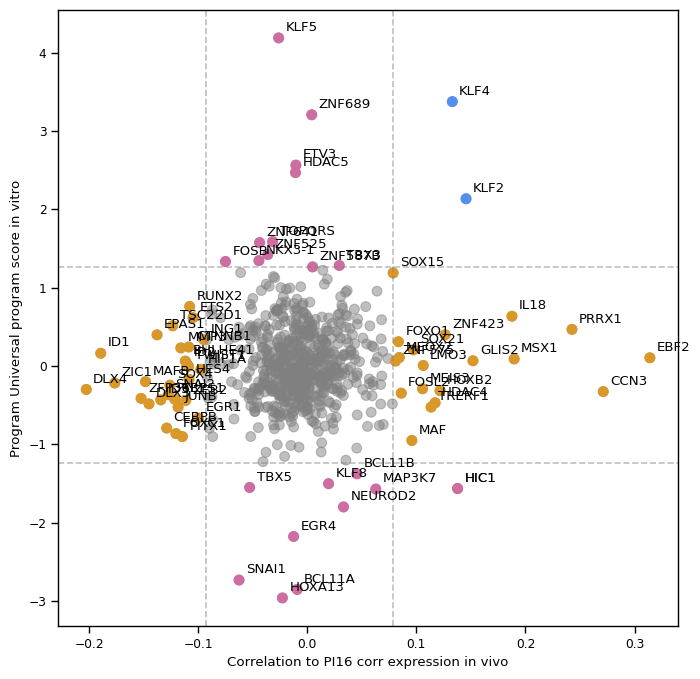

In [30]:
x_outliers, y_outliers, both_outliers = plot_and_identify_outliers(correlations['PI16'], gene_codes_reduced[31], 
                                                                   labels=['PI16 corr', 'Universal program'],
                                                                  savefig = True,
                                                                  context = 'explore')

Outliers in x-axis:
['ATF3', 'BCL6', 'BHLHE41', 'CEBPD', 'CREB3L1', 'EBF1', 'EGR1', 'EPAS1', 'ETV1', 'FOS', 'FOSB', 'HES4', 'HEY2', 'HEYL', 'HMGB2', 'ID2', 'IRF1', 'IRX3', 'JUN', 'JUNB', 'JUND', 'KLF2', 'KLF4', 'LEF1', 'LMO3', 'LRRFIP1', 'MEIS3', 'MEOX1', 'MEOX2', 'MSX1', 'MYC', 'NFIL3', 'NFKBIA', 'NFKBIZ', 'NR2F1', 'NR4A1', 'PLAGL1', 'RUNX2', 'SCX', 'SMAD1', 'SMARCA1', 'SNAI2', 'SOX12', 'TGFB1I1', 'TRIM27', 'TSC22D1', 'TSC22D3', 'ZBTB16', 'ZFP36L1', 'ZFP36L2', 'ZNF827']

Outliers in y-axis:
['EGR3', 'EPAS1', 'ERF', 'FEV', 'FOXF1', 'FOXL2', 'KLF5', 'KLF9', 'NEUROD1', 'NEUROD2', 'NR2F1', 'PLAG1', 'PLAGL1', 'POU3F2', 'RUNX3', 'SALL3', 'SATB1', 'STOX2', 'ZNF697']

Positive outliers in both axes:
['EPAS1', 'NR2F1', 'PLAGL1']


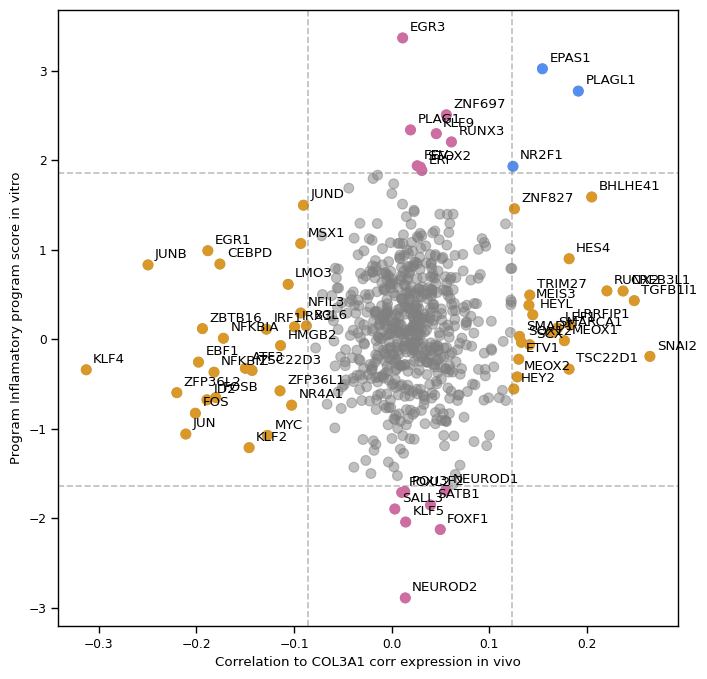

In [31]:
x_outliers, y_outliers, both_outliers = plot_and_identify_outliers(correlations['COL3A1'], gene_codes_reduced[32],
                                                                   labels=['COL3A1 corr', 'Inflamatory program'],
                                                                   savefig = True,
                                                                  context = 'explore'
                                                                  )